In [1]:
from WBT.whitebox_tools import WhiteboxTools
from PySAGA_cmd import SAGA
import rasterio
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import shutil
import math
from pathlib import Path
import time
import pandas as pd

path_to_saga_cmd_exe = r'D:\altsyplenkov\saga-9.3.2_x64\saga_cmd.exe'
saga = SAGA(path_to_saga_cmd_exe)

wbt = WhiteboxTools()

In [19]:
wbt.set_verbose_mode(False)

0

# Расчёт морфометрических величин

In [4]:
def Slope(input_dir):
    output_dir = r'D:\altsyplenkov\cw\surfaces\morpho\current_slope.tif'
    
    wbt.slope(
        dem = input_dir, 
        output = output_dir, 
        zfactor=None, 
        units="degrees"
    )

    with rasterio.open(output_dir, 'r') as ds:
        slope_data = ds.read()[0]
    
    return slope_data

In [5]:
def PlanCurvature(input_dir):
    output_dir = r'D:\altsyplenkov\cw\surfaces\morpho\current_hcurv.tif'
    
    wbt.plan_curvature(
        dem = input_dir, 
        output = output_dir, 
        log=False, 
        zfactor=None
    )

    with rasterio.open(output_dir, 'r') as ds:
        plan_curvature_data = ds.read()[0]
    
    return plan_curvature_data

In [6]:
def ProfileCurvature(input_dir):
    output_dir = r'D:\altsyplenkov\cw\surfaces\morpho\current_vcurv.tif'

    wbt.profile_curvature(
        dem = input_dir, 
        output = output_dir, 
        log=False, 
        zfactor=None
    )

    with rasterio.open(output_dir, 'r') as ds:
        profile_curvature_data = ds.read()[0]

    return profile_curvature_data

# Поиск оптимального алгоритма сглаживающей фильтрации:

In [14]:
start_time = time.time()
#os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
#wbt.set_working_dir(r'C:\Users\administrator\abstract_surfaces_cr')
# print(os.getcwd())
# Первый цикл, по типам поверхностей
with open(r'C:\Users\administrator\abstract_surfaces_cr\regardless.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerow(['Тип модели', 'Тип зашумления', 'Фильтр', 'Размер ячейки', 'Параметры',\
                     'Ср. значение высоты (исх.)', 'Ср. значение уклона (исх.)', 'Ср. значение hcurv (исх.)', 'Ср. значение vcurv (исх.)',\
                     'Ср. значения высоты (шум.)', 'Ср. значение уклона (шум.)', 'Ср. значение hcurv (шум.)', 'Ср. значение vcurv (шум.)',\
                     'Ср. значения высоты (фил.)', 'Ср. значения уклона (фил.)', 'Ср. значения hcurv (фил.)', 'Ср. значения vcurv (фил.)',\
                     'Метрика по высоте', 'Метрика по уклону', 'Метрика по гор. кривизне', 'Метрика по верт. кривизне'])
    for surface_type in ['hemicylinder', 'hemisphere', 'inclined', 'paraboloid']:
        #clear_dem = 'surfaces' + os.path.sep + 'clear' + os.path.sep + surface_type + '_clear.tif'
        clear_dem = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\clear\\' + surface_type + '_clear.tif'
        with rasterio.open(clear_dem, 'r') as ds:
            data_clear = ds.read()[0]
        mean_elev_clear = np.mean(data_clear)
        mean_slope_clear = np.mean(Slope(clear_dem))
        mean_hcurv_clear = np.mean(PlanCurvature(clear_dem))
        mean_vcurv_clear = np.mean(ProfileCurvature(clear_dem))
    
        # Второй цикл, по типам шума
        for noise_type in ['_n_05', "_n_1", '_n_2', '_un_05', '_un_1', '_un_2']:
            #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
            #noisy_dem = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'noisy' + os.path.sep + surface_type + noise_type + '.tif'
            noisy_dem = r'C:\Users\administrator\abstract_surfaces_cr\surfaces\noisy\\' + surface_type + noise_type + '.tif'
            with rasterio.open(noisy_dem, 'r') as ds:
                data_noisy = ds.read()[0]
            mean_elev_noisy = np.mean(data_noisy)
            mean_slope_noisy = np.mean(Slope(noisy_dem))
            mean_hcurv_noisy = np.mean(PlanCurvature(noisy_dem))
            mean_vcurv_noisy = np.mean(ProfileCurvature(noisy_dem))
            #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
            # Третий цикл, по фильтрам - не цикл, а вызовы отдельных функций!
            # Четвёртый цикл: по параметрам фильтров
            
            for kernel_size in [3, 5, 7, 11, 15]:

                output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_Mean_' + str(kernel_size) + '.tif'
                #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                #    + os.path.sep + surface_type + noise_type + '_Mean_' + str(kernel_size) + '.tif'  # тип фильтра прописывается здесь!
                wbt.mean_filter(noisy_dem, output_path, kernel_size, kernel_size)
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
    
                with rasterio.open(output_path, 'r') as ds:
                    data_filtered = ds.read()[0]
                mean_elev_filtered = np.mean(data_filtered)
                mean_slope_filtered = np.mean(Slope(output_path))
                mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                
                metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))

                writer.writerow([surface_type, noise_type, 'MeanFilter', kernel_size, '-',\
                                str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                metric_elevation, metric_slope, metric_hcurv, metric_vcurv])
    
                #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                #    + os.path.sep + surface_type + noise_type + '_Median_' + str(kernel_size) + '.tif'  # тип фильтра прописывается здесь!
                output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_Median_' + str(kernel_size) + '.tif'
                wbt.median_filter(noisy_dem, output_path, kernel_size, kernel_size)
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
    
                with rasterio.open(output_path, 'r') as ds:
                    data_filtered = ds.read()[0]
                mean_elev_filtered = np.mean(data_filtered)
                mean_slope_filtered = np.mean(Slope(output_path))
                mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                
                metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))

                writer.writerow([surface_type, noise_type, 'MedianFilter', kernel_size, None,\
                                str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                metric_elevation, metric_slope, metric_hcurv, metric_vcurv])

                output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_ConservativeSmoothing_' + str(kernel_size) + '.tif'
                #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                #    + os.path.sep + surface_type + noise_type + '_ConservativeSmoothing_' + str(kernel_size) + '.tif'  # тип фильтра прописывается здесь!
                wbt.conservative_smoothing_filter(noisy_dem, output_path, kernel_size, kernel_size)
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
    
                with rasterio.open(output_path, 'r') as ds:
                    data_filtered = ds.read()[0]
                mean_elev_filtered = np.mean(data_filtered)
                mean_slope_filtered = np.mean(Slope(output_path))
                mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                
                metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))
                writer.writerow([surface_type, noise_type, 'ConservativeSmoothingFilter', kernel_size, '-',\
                                str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                metric_elevation, metric_slope, metric_hcurv, metric_vcurv])
                
                output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_Majority_' + str(kernel_size) + '.tif'
                #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                #    + os.path.sep + surface_type + noise_type + '_Majority_' + str(kernel_size) + '.tif'  # тип фильтра прописывается здесь!
                wbt.majority_filter(noisy_dem, output_path, kernel_size, kernel_size)
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
    
                with rasterio.open(output_path, 'r') as ds:
                    data_filtered = ds.read()[0]
                mean_elev_filtered = np.mean(data_filtered)
                mean_slope_filtered = np.mean(Slope(output_path))
                mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                
                metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))

                writer.writerow([surface_type, noise_type, 'MajorityFilter', kernel_size, '-',\
                                str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                metric_elevation, metric_slope, metric_hcurv, metric_vcurv])

                output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_Olympic_' + str(kernel_size) + '.tif'
                #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                #    + os.path.sep + surface_type + noise_type + '_Olympic_' + str(kernel_size) + '.tif'  # тип фильтра прописывается здесь!
                wbt.olympic_filter(noisy_dem, output_path, kernel_size, kernel_size)
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
    
                with rasterio.open(output_path, 'r') as ds:
                    data_filtered = ds.read()[0]
                mean_elev_filtered = np.mean(data_filtered)
                mean_slope_filtered = np.mean(Slope(output_path))
                mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                
                metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))

                writer.writerow([surface_type, noise_type, 'OlympicFilter', kernel_size, '-',\
                                str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                metric_elevation, metric_slope, metric_hcurv, metric_vcurv])
                                
                for threshold in np.arange(0.1, 2.1, 0.1):
                    threshold = round(threshold, 2)
                    output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_Adaptive_' + str(kernel_size) + str(threshold) +'.tif'
                    #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                    #    + os.path.sep + surface_type + noise_type + '_Adaptive_' + str(kernel_size) + str(threshold) + '.tif'  # тип фильтра прописывается здесь!
                    wbt.adaptive_filter(noisy_dem, output_path, kernel_size, kernel_size, threshold)
                    #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
                    
                    with rasterio.open(output_path, 'r') as ds:
                        data_filtered = ds.read()[0]
                    mean_elev_filtered = np.mean(data_filtered)
                    mean_slope_filtered = np.mean(Slope(output_path))
                    mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                    mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                    #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                    
                    metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                    metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                    metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                    metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))
                                
                    writer.writerow([surface_type, noise_type, 'AdaptiveFilter', str(kernel_size), str(threshold),\
                                str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                metric_elevation, metric_slope, metric_hcurv, metric_vcurv])

                    output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_EdgePreservingMean_' + str(kernel_size) + str(threshold) + '.tif'
                    #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                    #    + os.path.sep + surface_type + noise_type + '_EdgePreservingMean_' + str(kernel_size) + str(threshold) + '.tif'  # тип фильтра прописывается здесь!
                    wbt.edge_preserving_mean_filter(noisy_dem, output_path, kernel_size, threshold)
                    #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
    
                    with rasterio.open(output_path, 'r') as ds:
                        data_filtered = ds.read()[0]
                    mean_elev_filtered = np.mean(data_filtered)
                    mean_slope_filtered = np.mean(Slope(output_path))
                    mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                    mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                    os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                    
                    metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                    metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                    metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                    metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))

                    writer.writerow([surface_type, noise_type, 'EdgePreservingMeanFilter', str(kernel_size), str(threshold),\
                                    str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                    str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                    str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                    metric_elevation, metric_slope, metric_hcurv, metric_vcurv])
                
                #for norm_diff in range(5, 46, 5):
                for norm_diff in [5]:
                    for num_iter in range(2, 40):
                        if noise_type.split('_')[-2] == 'n':
                            max_diff = 10
                        else: max_diff = 2
                        output_path = r'D:\altsyplenkov\cw\surfaces\filtered\\' + surface_type + noise_type + '_FPDEMS_' + str(kernel_size)  + str(norm_diff) + f'_{str(num_iter)}_{str(max_diff)}' + '.tif'
                        #output_path = os.getcwd() + os.path.sep + 'surfaces' + os.path.sep + 'filtered' \
                        #    + os.path.sep + surface_type + noise_type + '_FPDEMS_' + str(kernel_size) + str(norm_diff) + f'_{str(num_iter)}_{str(max_diff)}' + '.tif'  # тип фильтра прописывается здесь!
                        wbt.feature_preserving_smoothing(noisy_dem, output_path, kernel_size, norm_diff, num_iter, max_diff)
                        #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr') # костыль под Whitebox
    
                        with rasterio.open(output_path, 'r') as ds:
                            data_filtered = ds.read()[0]
                        mean_elev_filtered = np.mean(data_filtered)
                        mean_slope_filtered = np.mean(Slope(output_path))
                        mean_hcurv_filtered = np.mean(PlanCurvature(output_path))
                        mean_vcurv_filtered = np.mean(ProfileCurvature(output_path))
                        #os.chdir(r'C:\Users\administrator\abstract_surfaces_cr')
                        
                        metric_elevation = abs(((mean_elev_filtered - mean_elev_clear)/mean_elev_clear) / ((mean_elev_noisy - mean_elev_clear)/mean_elev_clear))
                        metric_slope = abs(((mean_slope_filtered - mean_slope_clear)/mean_slope_clear) / ((mean_slope_noisy - mean_slope_clear)/mean_slope_clear))
                        metric_hcurv = abs(((mean_hcurv_filtered - mean_hcurv_clear)/mean_hcurv_clear) / ((mean_hcurv_noisy - mean_hcurv_clear)/mean_hcurv_clear))
                        metric_vcurv = abs(((mean_vcurv_filtered - mean_vcurv_clear)/mean_vcurv_clear) / ((mean_vcurv_noisy - mean_vcurv_clear)/mean_vcurv_clear))                           
            
                        writer.writerow([surface_type, noise_type, 'FPDEMS', kernel_size, str([norm_diff, num_iter, max_diff]),\
                                        str(mean_elev_clear), str(mean_slope_clear), str(mean_hcurv_clear), str(mean_vcurv_clear),\
                                        str(mean_elev_noisy), str(mean_slope_noisy), str(mean_hcurv_noisy), str(mean_vcurv_noisy),\
                                        str(mean_elev_filtered), str(mean_slope_filtered), str(mean_hcurv_filtered), str(mean_vcurv_filtered),\
                                        metric_elevation, metric_slope, metric_hcurv, metric_vcurv])

    
            # Дописать другие типы фильтров: отдельные блоки, не цикл! 
            # Цикл можно сделать, если есть ещё параметры, кроме размера скользящего окна

           

            # Выводить всё в табличный файл: тип поверхности, тип шума, тип фильтра (!), размер ячейки, параметры фильтра, значения средних и СКО (сырые, включая исходную и шумную модель), метрики
            # print(noise_type, kernel_size, mean_elev_clear, mean_elev_noisy, mean_elev_filtered, metric_elevation)
csvfile.close()

await send_telegram_message(f"Ячейка выполнена\! Время выполнения\: {int((time.time() - start_time) / 60)} минут")        
await send_file_to_telegram(r'C:\Users\administrator\abstract_surfaces_cr\regardless.csv')

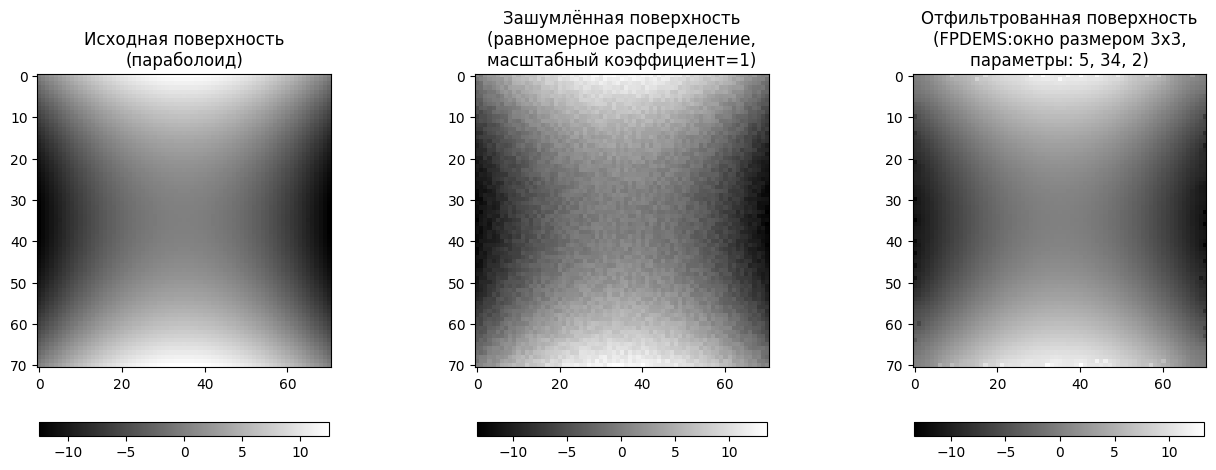

In [9]:
fig = plt.figure(figsize=(16, 16))

ax1 = fig.add_subplot(3, 3, 1)
ax1.set_title('Исходная поверхность\n(параболоид)')
plt.imshow(data_clear, cmap='binary_r')
plt.colorbar(fraction=0.04, orientation='horizontal')

ax2 = fig.add_subplot(3, 3, 2)
ax2.set_title('Зашумлённая поверхность\n(равномерное распределение,\nмасштабный коэффициент=1)')
plt.imshow(data_noisy, cmap='binary_r')
plt.colorbar(fraction=0.04, orientation='horizontal')

ax3 = fig.add_subplot(3, 3, 3)
ax3.set_title('Отфильтрованная поверхность\n(FPDEMS:окно размером 3x3,\nпараметры: 5, 34, 2)')
plt.imshow(data_filtered, cmap='binary_r')
plt.colorbar(fraction=0.04, orientation='horizontal')

plt.savefig('FPDEMS_RES.png')